In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

from qiskit import BasicAer
from qiskit.circuit.library import ZZFeatureMap, PauliFeatureMap
from qiskit.aqua import QuantumInstance, aqua_globals
from qiskit.aqua.algorithms import QSVM
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name

seed = 10599
aqua_globals.random_seed = seed
import warnings
warnings.filterwarnings('ignore')

<ipython-input-1-2b95b306fbfc>:13: DeprecationWarning: The variable qiskit.aqua.aqua_globals is deprecated. It was moved/refactored to qiskit.utils.algorithm_globals (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  aqua_globals.random_seed = seed


In [2]:
from qiskit.aqua.components.optimizers import COBYLA
from qiskit.aqua.components.feature_maps import RawFeatureVector
from qiskit.circuit.library import TwoLocal
import functools

In [5]:
os_dataset = pd.read_excel('co1_attainment_OS.xlsx', engine='openpyxl')

os_dataset.head()

,NAMES,MS 1 52%,MS 2 0%,MS 3 0%,ASSIGNMENT 40%,SEM RESULT 22%,TOTAL 114%,OBTAINED FOR 100,Threshold 60%
0,AARTHI.P.,41.60,0,0,40.0,22.0,103.60,90.877193,Y
1,ABDUL KHADI.K.,14.56,0,0,40.0,15.4,69.96,61.368421,Y
2,ABINAYA.N.,39.52,0,0,40.0,19.8,99.32,87.122807,Y
3,AKALYA.M.,20.80,0,0,40.0,17.6,78.40,68.771930,Y
4,ARCHANADEVI@KAMATCHI R.,33.28,0,0,40.0,17.6,90.88,79.719298,Y


In [8]:
df = os_dataset.copy()
df.drop(['NAMES','MS 2 0%','MS 3 0%'], axis = 1, inplace = True)
df['Threshold 60%'].replace(to_replace=['Y', 'N'], value=[1, 0], inplace=True)
df.head()

,MS 1 52%,ASSIGNMENT 40%,SEM RESULT 22%,TOTAL 114%,OBTAINED FOR 100,Threshold 60%
0,41.60,40.0,22.0,103.60,90.877193,1
1,14.56,40.0,15.4,69.96,61.368421,1
2,39.52,40.0,19.8,99.32,87.122807,1
3,20.80,40.0,17.6,78.40,68.771930,1
4,33.28,40.0,17.6,90.88,79.719298,1


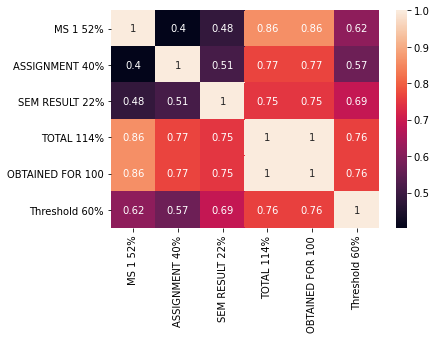

In [9]:
import seaborn as sns
corr = df.corr()
sns.heatmap(corr, annot=True)

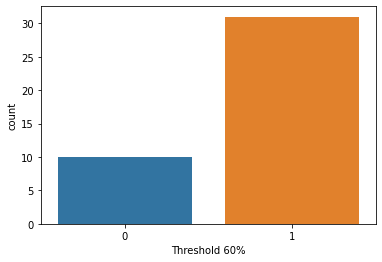

In [10]:
sns.countplot(df['Threshold 60%'])

## Classical ML model

In [11]:
X = df.iloc[:,range(5)].values
y = df.iloc[:,5].values
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 0)

In [15]:
from sklearn.linear_model import LogisticRegression
lr_classifier = LogisticRegression()
lr_classifier.fit(X_train, y_train)
print("score on test: " + str(lr_classifier.score(X_test, y_test)))
print("score on train: "+ str(lr_classifier.score(X_train, y_train)))

score on test: 1.0
score on train: 1.0


In [14]:
from sklearn.naive_bayes import GaussianNB
mnb_classifier = GaussianNB().fit(X_train, y_train)
mnb_classifier.fit(X_train, y_train)
print("score on test: " + str(mnb_classifier.score(X_test, y_test)))
print("score on train: "+ str(mnb_classifier.score(X_train, y_train)))

score on test: 1.0
score on train: 0.9583333333333334


## QSVM

In [16]:
vals = df[df.columns[:-1]].values

In [17]:
def custom_data_map_func(x):
    """Define a function map from R^n to R.
    
    Args:
        x (np.ndarray): data
    Returns:
        double: the mapped value
    """
    coeff = x[0] if len(x) == 1 else functools.reduce(lambda m, n: m * n, np.pi - x)
    return coeff

In [18]:
train_input = vals[:25]
test_input = vals[25:]

training_data = {1:[],0:[]} # 1 == 'A' and 0 == 'B'
for i in range(len(train_input)):
    if df['Threshold 60%'][i] == 1:
        training_data[1].append(train_input[i].tolist())
    else:
        training_data[0].append(train_input[i].tolist())
        
testing_data = {1:[],0:[]} # 1 == 'A' and 0 == 'B'
for i in range(len(test_input)):
    if df['Threshold 60%'][i] == 1:
        testing_data[1].append(test_input[i].tolist())
    else:
        testing_data[0].append(test_input[i].tolist())

In [19]:
def qsvm_testing_accuracy(training_data, testing_data, feature_dim, reps, entanglement):
    feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=reps, entanglement=entanglement,  data_map_func=custom_data_map_func)
    
    qsvm = QSVM(feature_map, training_data, testing_data)

    backend = BasicAer.get_backend('qasm_simulator')
    quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)
    result = qsvm.run(quantum_instance)
    print('Testing Accuracy for reps={} and entanglement={}: '.format(reps, entanglement), result['testing_accuracy'])
    return

In [21]:
lst = ['linear', 'circular', 'full']

feature_dim = 5

for i in range(len(lst)):
    for j in lst:
        qsvm_testing_accuracy(training_data, testing_data, feature_dim, i+1, j)


Testing Accuracy for reps=1 and entanglement=linear:  0.9375
Testing Accuracy for reps=1 and entanglement=circular:  0.9375
Testing Accuracy for reps=1 and entanglement=full:  0.9375
Testing Accuracy for reps=2 and entanglement=linear:  0.875
Testing Accuracy for reps=2 and entanglement=circular:  0.9375
Testing Accuracy for reps=2 and entanglement=full:  0.9375
Testing Accuracy for reps=3 and entanglement=linear:  0.9375
Testing Accuracy for reps=3 and entanglement=circular:  0.9375
Testing Accuracy for reps=3 and entanglement=full:  0.9375


In [22]:
reps = 1
entanglement = 'linear'
feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=reps, entanglement=entanglement,  data_map_func=custom_data_map_func)
    
final_qsvm = QSVM(feature_map, training_data, testing_data)

backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)
result = final_qsvm.run(quantum_instance)
result['testing_accuracy']

0.9375

## VQC

In [23]:
from qiskit.aqua.algorithms import VQC

In [25]:
feature_dim = 5

#feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2, entanglement='full')
#feature_map = PauliFeatureMap(feature_dimension=feature_dim, reps=2, paulis=['ZZ'])
feature_map = RawFeatureVector(feature_dimension=feature_dim)

vqc = VQC(COBYLA(maxiter=100),
          feature_map,
          TwoLocal(feature_map.num_qubits, ['ry', 'rz'], 'cz', reps=3),
          training_dataset = training_data,
          test_dataset = testing_data)

result = vqc.run(QuantumInstance(BasicAer.get_backend('statevector_simulator'),
                                 shots=1024, seed_simulator=seed, seed_transpiler=seed))

print('Testing accuracy: {:0.2f}'.format(result['testing_accuracy']))
print(result)

Testing accuracy: 0.94
{'num_optimizer_evals': 100, 'min_val': 0.3019760941357888, 'opt_params': array([ 0.3070754 , -2.79652246,  0.83834916, -0.607384  ,  1.07220706,
        0.53382782,  1.23363164,  0.61143112,  0.82422264,  1.45996048,
       -0.85186916, -0.64740347,  0.89131321,  0.12754001,  0.24443571,
       -0.46246378, -1.95947024, -1.26957252, -0.02244251,  0.83299872,
       -1.37421566, -0.09357117,  1.52229812, -1.08463754]), 'eval_time': 475.6486966609955, 'eval_count': 100, 'training_loss': 0.3019760941357888, 'testing_accuracy': 0.9375, 'test_success_ratio': 0.9375, 'testing_loss': 0.24361292536733897}


Both QSVM and VQC performed equally well.